# Data Analysis and preprocessing pipeline

This notebook is used for image data analysis and dataset creation for unsupervised face detection algorithms. Face recognition algorithms aim to find embedding vector for individual face, we assumed that each face has individual embedding vector which can be used for distance measurement.

Data will be split into two parts, one for the PCA algorithm, second for the Siamese network. Datasets vary by dimension, PCA has [anchor, negative/positive] images while Siamese dataset has [anchor, positive, negative].


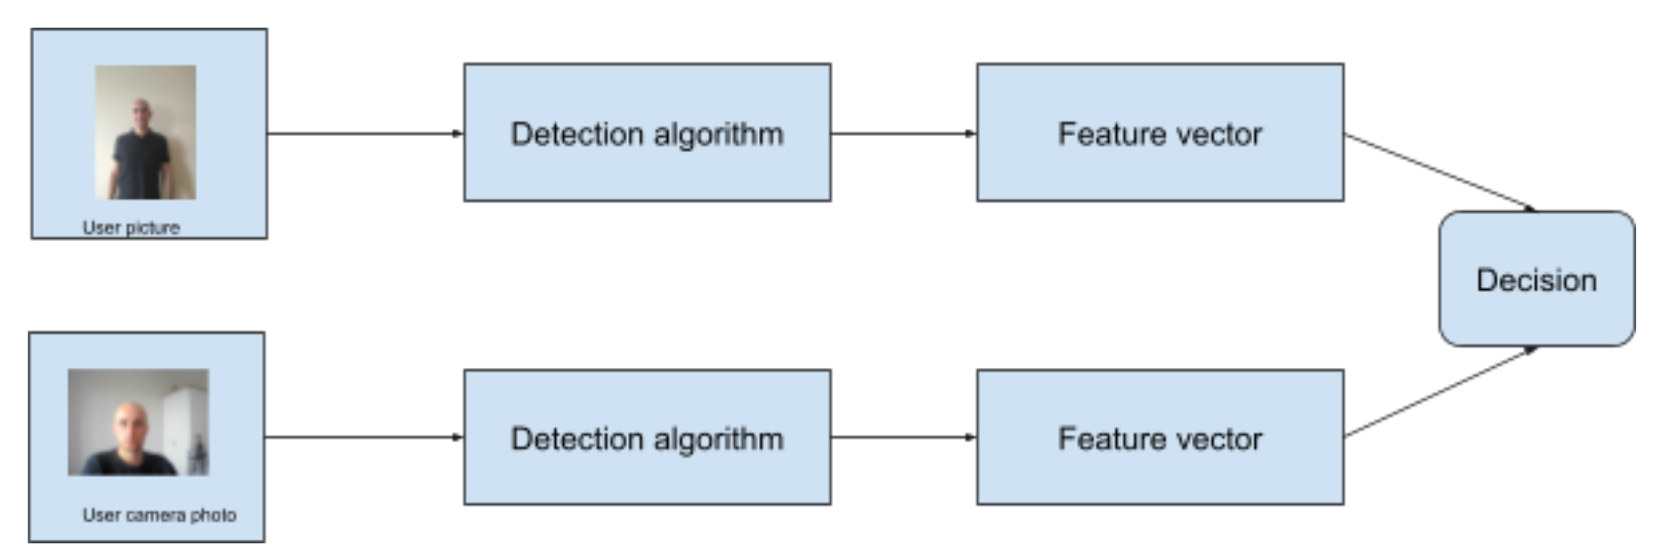

**Labeled Faces in the Wild Data**

For the capstone purpose, I will use Labeled Faces in the Wild. LFW is a public benchmark for face verification, also known as pair matching. The data set contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. For more information about the dataset, please enter the [official website](http://vis-www.cs.umass.edu/lfw/)

**Machine Learning Workflow**

To test different unsupervised algorithms, I will go through several steps:

- Data loading and exploration
- Split data into train/test/val sets and process for different algorithms


Traning, deploy, and testing algorithms notebooks will be described in the next notebooks.


This notebook is assumed to make up a complete, machine learning preprocessing step from data loading and cleaning to save data on s3. Each step will be described and results will be saved on S3 with Sagemaker and Boto3 SDK.

### Install packages, loading libraries, and create environment variables

In [1]:
# install needed library for the environment
!pip install tqdm

     |████████████████████████████████| 75 kB 5.0 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
# import libraries
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.auto import tqdm
from typing import Optional
# plot settings
plt.rcParams["figure.figsize"] = (10,10)



# create local environment variables
RANDOM_SEED = 42 # random seed for reproducibility
RAW_DATA_CATALOG = './data/raw' # path to save LFW dataset locally
MIN_FACE_PER_PERSON = 12 # minimum number of face to download

# add random seed to make reproducibility
np.random.seed(RANDOM_SEED)

## Data loading and exploration

The LFW dataset is available through the scikit-learn library, only the data for which the minimum number of face photos is greater than or equal to 12 (*MIN_FACE_PER_PERSON* variable) are loaded. Data will be saved on local storage, then dump it to S3 as a raw dataset.

In [3]:
# download raw data to specific catalog and load y/X datasets
data = fetch_lfw_people(data_home=RAW_DATA_CATALOG,
                        min_faces_per_person=MIN_FACE_PER_PERSON,
                        return_X_y=False)

### Draw samples and feature analysis

In this section, I will create a simple analysis for the image dataset. First, I created auxiliary functions that are responsible for image analysis, then I created plots for labels and the number of occurrences of individual people.

In [4]:
# create additional functions

def _sample_image_label(labels: np.array) -> tuple:
    "Return index of images and index of labels for samples"
    idx = np.random.choice(labels, size=1, replace=False)
    images_idx = np.random.choice(len(labels[labels==idx]), size=3, replace=False)
    return idx, images_idx

def _sample_image_matrix(images: np.array) -> tuple:
    "Return index of images for samples"
    idx = np.random.choice(len(images), size=1, replace=False)
    return idx

def mean_image(images: np.array, labels: np.array, label: int) -> np.array:
    """Create mean image from all images with a specific label
    images: np.array
        Images data
    labels: np.array
        Labels for image data
    label: int
        Specific label for face for extract mean face
    """
    assert images.shape[0] == labels.shape[0], f'Labels and Images must have same shape'
    return images[labels==label].mean(axis=0)

def draw_sample(image_data: np.array, labels: Optional[np.array] = None, n: int = 5) -> None:
    "Draw samples of the image"
    fig, ax = plt.subplots(n, 3)
    for i, axi in enumerate(ax.flat):
        if i % 3 == 0:
            if labels is not None:
                idx, images_idx = _sample_image_label(labels)
                faces = image_data[labels==idx][images_idx].reshape(3, 62, 47)
            else:
                idx = _sample_image_matrix(image_data)
                faces = image_data[idx].reshape(3, 62, 47)
                
        axi.imshow(faces[i % 3], cmap='bone')
        axi.set(xticks=[], yticks=[], xlabel=f'Label: {idx[0]}')

<AxesSubplot:xlabel='label_index', ylabel='Count'>

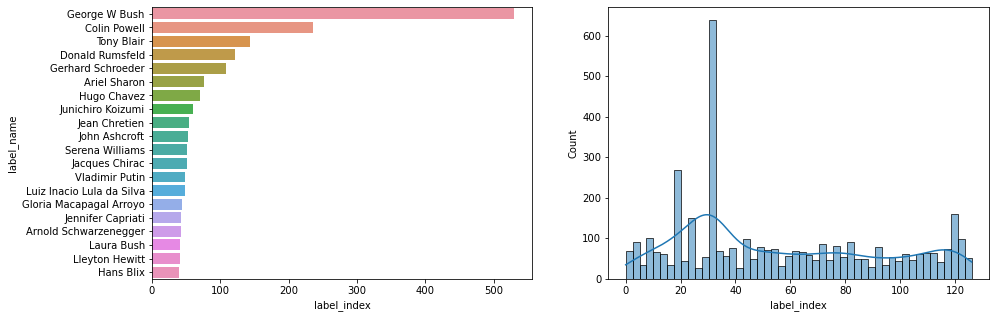

In [5]:
MAX_FACES = 20
# create axis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# create dataframe from labels and names
df = pd.DataFrame({'label_index': data.target})
df['label_name'] = df.label_index.apply(lambda x: data.target_names[x])
sorted_faces = df.groupby(by='label_name').count().sort_values(by='label_index', ascending=False).iloc[:MAX_FACES]

# plot the most common faces in the dataset
sns.barplot(ax=axes[0], y=sorted_faces.index, x=sorted_faces.label_index)

# plot histogram based on labels
sns.histplot(ax=axes[1], data=df, x="label_index", kde=True, bins=50)

We see that the large number of faces are politicians, especially men. Additionally, the number of photos of George W. Bush and Colin Powell are overestimated. During the process of creating training and test sets, the number of images for the given people should be normalized.

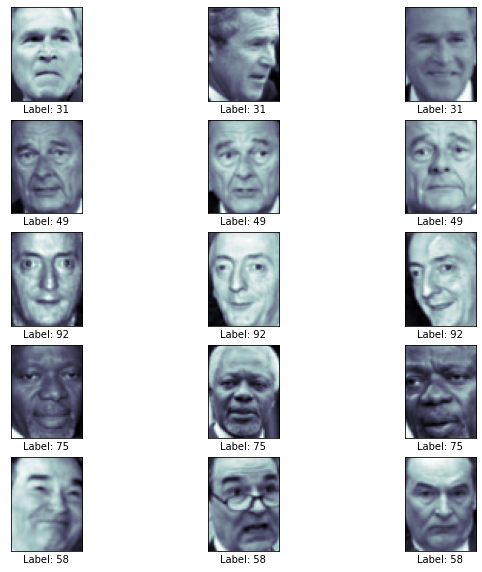

In [6]:
draw_sample(data.images, data.target)

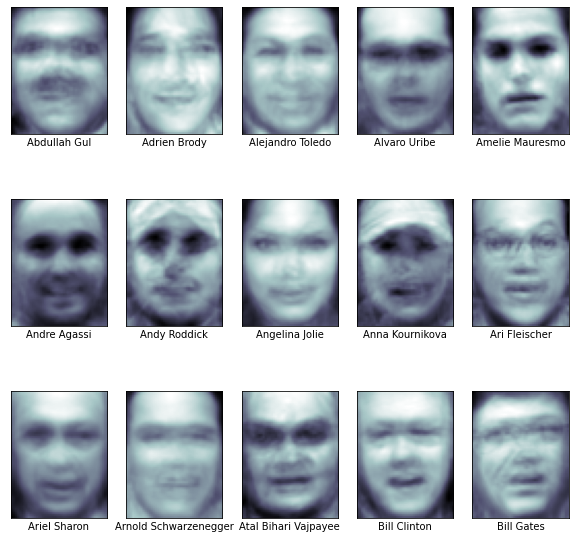

In [7]:
# draw mean face samples
fig, ax = plt.subplots(3, 5, figsize=(10, 10))

for i, axi in enumerate(ax.flat):
    name = data.target_names[i]
    image = mean_image(data.images, data.target, i)
    axi.imshow(image, cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=name)

Above we see average per-pixel images of the sample photos in the dataset. You can see that the faces differ in particular with the positioning of the eyes, the nose, and the mouth. Additionally, glasses are visible on some people's faces, which may hinder the process of recognizing them.

## Split data into train/test / val sets and process for different algorithms

In this section I will split data into different pairs of images, the entire dataset will be divided into test, training, and validation set. The data will be paired
 - For PCA to [anchor / positive or negative] pairs to increase the number of positive and negative examples
 - For Siamese Network to [anchor, positive, negative] pairs, this will allow using triplet loss during training.

Then the data will be saved to local disks and later transfer to S3. Data will be further used for training, test, and validation of results.

In [8]:
def _positive_pairs(images, labels, n=2):
    "Create positive n pairs for images"
    positive_pairs = list()
    for image, idx in zip(images, labels):
        for _ in range(n):
            image_idx = np.random.choice(images[labels == idx].shape[0], size=10, replace=False)
            print(random.choice(image_idx))
            print(image_idx)
            positive_image = images[labels == idx][random.choice(image_idx)]
            positive_pairs.append(np.hstack((positive_image, image)))
    return np.array(positive_pairs)


def _create_pairs(images, labels, n=2):
    "Create negative n pairs for images"
    triplet_pairs = list()
    unique_labels = np.unique(labels)
    for label in tqdm(unique_labels, total=len(unique_labels)):
        for _ in range(n):
            # get positive image
            try:
                image_idx = np.random.choice(images[labels == label].shape[0], size=2, replace=False)
            except ValueError:
                # when we don't have two different faces of the same person continue
                continue
            positive_images = images[labels == label][image_idx]
            # get negative image
            image_idx = np.random.choice(images[labels != label].shape[0], size=1, replace=False)
            negative_image = images[labels != label][image_idx]
            triplet_pairs.append(np.concatenate((positive_images, negative_image), axis=0))
    # reshape data and returns
    return np.array(triplet_pairs).reshape(len(triplet_pairs), 3, 2914)


def create_pca_set(image_data, labels, n=2, test_size=0.3):
    # TODO: add asserts
    assert image_data.shape[0] == labels.shape[0]
    "Create X/y dataset for pca"
    # create pairs
    pairs = _create_pairs(image_data, labels, n=n)
    positive_pairs = pairs[:, :2]
    negative_pairs = np.hstack((pairs[:, 0:1, :], pairs[:, 2:, :]))
    data = np.vstack((positive_pairs, negative_pairs))

    # create labels
    labels = np.hstack(([1] * len(pairs), [0] * len(pairs)))
    return data, labels


def create_triplet_set(image_data, labels, n):
    "Create sets for triplet set with anchor/positive/negative"
    # TODO: add asserts
    assert image_data.shape[0] == labels.shape[0]
    # create pairs
    data = _create_pairs(image_data, labels, n=n*2)
    # check vstack
    return data


def save_numpy(X, y, directory, set_name, suffix):
    "Save dataset as numpy frame to disk"
    X_name = os.path.join(directory, f'X_{set_name}_{suffix}.npy')
    np.save(X_name, X)
    if y is not None:
        y_name = os.path.join(directory, f'y_{set_name}_{suffix}.npy')
        np.save(y_name, y)
    print('Succesfully save')

## Creating datasets

In [9]:
# split data to train/test/val
image_data = data.images
labels = data.target

X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2,
                                                    random_state=RANDOM_SEED, stratify=labels)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,
                                                  random_state=RANDOM_SEED, stratify=y_train) # 0.25 x 0.8 = 0.2

# create train sets
print("Creating train datasets")
X_train_pca, y_train_pca = create_pca_set(image_data=X_train, labels=y_train, n=8)
X_train_siamese = create_triplet_set(image_data=X_train, labels=y_train, n=8)
print("============")
print(f'PCA train data size: {X_train_pca.shape[0]}')
print(f'Siamese train data size: {X_train_siamese.shape[0]}')
print("============")
# create test sets
print("Creating test datasets")
X_test_pca, y_test_pca = create_pca_set(image_data=X_test, labels=y_test, n=2)
X_test_siamese = create_triplet_set(image_data=X_test, labels=y_test, n=2)
print("============")
print(f'PCA test data size: {X_test_pca.shape[0]}')
print(f'Siamese train data size: {X_test_siamese.shape[0]}')
print("============")
# create valid sets
print("Creating val datasets")
print("============")
X_val_pca, y_val_pca = create_pca_set(image_data=X_val, labels=y_val, n=1)
print(f'Validation data size: {X_val_pca.shape[0]}')
print("============")

Creating train datasets


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

PCA train data size: 2032
Siamese train data size: 2032
Creating test datasets


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

PCA test data size: 508
Siamese train data size: 508
Creating val datasets


  0%|          | 0/127 [00:00<?, ?it/s]

Validation data size: 254


## Draw dataset sample

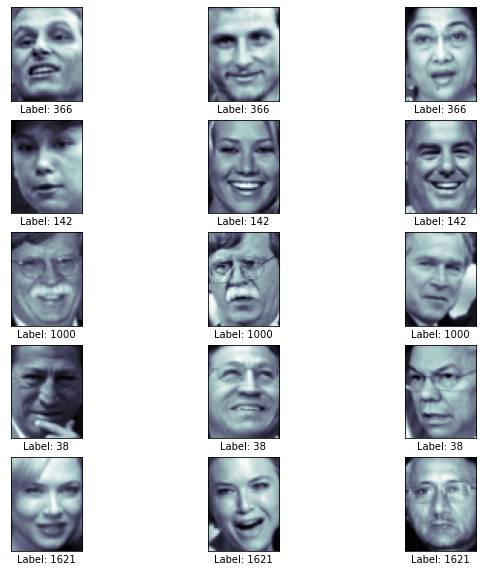

In [10]:
draw_sample(X_train_siamese)

## Save dataset into local directory and S3 storage

In [11]:
DATA_DIR = './data/processed'

# save train data
save_numpy(X_train_pca, y_train_pca, DATA_DIR, 'train', 'pca')
save_numpy(X_train_siamese, None, DATA_DIR, 'train', 'siamese')
# save test data
save_numpy(X_test_pca, y_test_pca, DATA_DIR, 'test', 'pca')
save_numpy(X_test_siamese, None, DATA_DIR, 'test', 'siamese')
# save validation data
save_numpy(X_val_pca, y_val_pca, DATA_DIR, 'val', 'final')

Succesfully save
Succesfully save
Succesfully save
Succesfully save
Succesfully save


In [12]:
import sagemaker
import boto3
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'ml_capstone/face_recognition'

role = sagemaker.get_execution_role()

input_data = sagemaker_session.upload_data(path=DATA_DIR, bucket=bucket, key_prefix=prefix)